In [65]:
import numpy as np
import matplotlib.pyplot as plt
from localization import datasets, models, samplers
from localization.utils import build_DRT, iterate_kron, build_gaussian_covariance
import jax
import jax.numpy as jnp
from jax.scipy.special import erf as gain_function

## 1D

In [66]:
def periodic_convolve(x, h):
    """Periodic convolution of x with h."""
    # make sure h is 2D if x is
    if len(x.shape) == 2:
        h = h[None, :]
    # pad to the same length
    if x.shape[-1] < h.shape[-1]:
        x = jnp.pad(x, (0, h.shape[-1] - x.shape[-1]))
    elif x.shape[0] > h.shape[0]:
        h = jnp.pad(h, (0, x.shape[-1] - h.shape[-1]))
    return jnp.fft.ifft(jnp.fft.fft(x) * jnp.fft.fft(h)).real

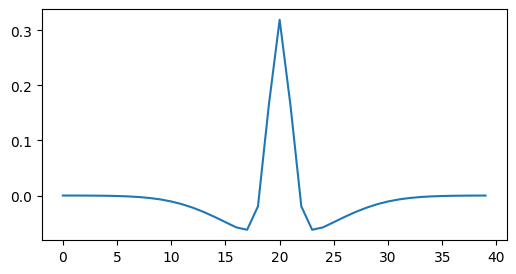

In [71]:
def on_center_off_surround(filter_size, center, surround):
    dist = jnp.arange(filter_size) - (filter_size / 2)
    on = jnp.exp(-dist ** 2 / (2 * center ** 2)) / jnp.sqrt(2 * np.pi * center ** 2)
    off = jnp.exp(-dist ** 2 / (2 * surround ** 2)) / jnp.sqrt(2 * np.pi * surround ** 2)
    return on - off
# ncfs = on_center_off_surround(16, 0.5, 1)
# ncfs = on_center_off_surround(16, 0.5, 2)
# ncfs = on_center_off_surround(40, 0.25, 1.5)
# ncfs = on_center_off_surround(40, 1, 3) # GOOD
ncfs = on_center_off_surround(40, 1, 5)
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
_ = ax.plot(ncfs)

In [75]:
num_dimensions = 40
config = dict(
    num_dimensions=num_dimensions,
    xi1=1,
    xi2=1,
    gain=0.01,#100,
    dim=1,
    seed=0,
    key=jax.random.PRNGKey(0),
)
dataset = datasets.NonlinearGPDataset(**config)
x, y = dataset[:2000]
whitened = periodic_convolve(x, ncfs)

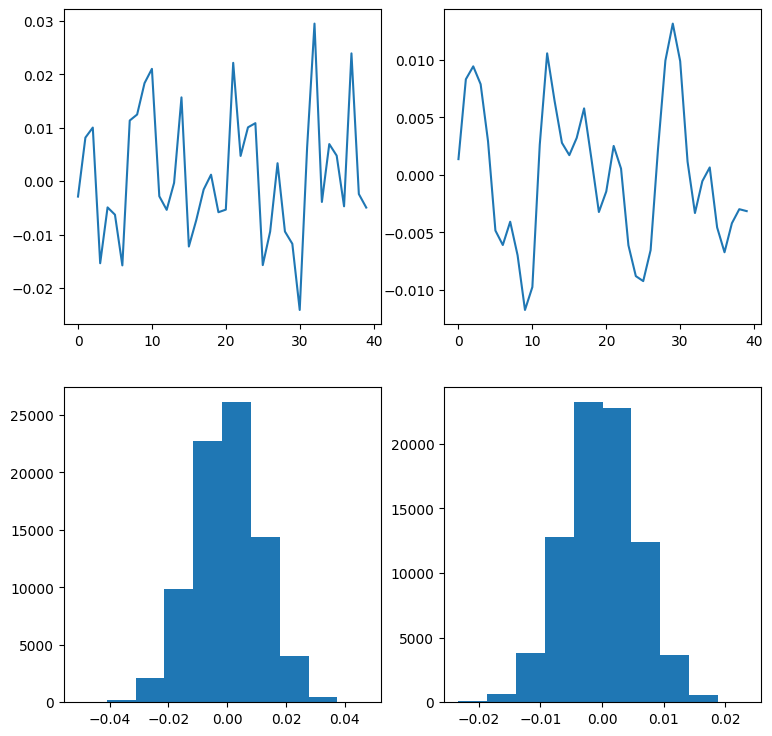

In [76]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
# before whitening
_ = axs[0,0].plot(x[0])
# after whitening
# whitened = periodic_convolve(x[0], ncfs); axs[0,1].plot(whitened); axs[1,1].hist(whitened.flatten())
_ = axs[0,1].plot(whitened[0])
# marginals
_ = axs[1,0].hist(x.flatten())
_ = axs[1,1].hist(whitened.flatten())

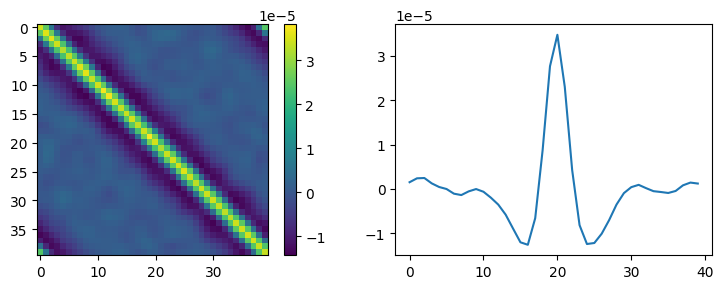

In [77]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))
cov = np.cov(whitened.T)
im = ax1.imshow(cov)
cbar = fig.colorbar(im, ax=ax1)
_ = ax2.plot(cov[20])

It looks like a Gabor... is this obvious or not?

### Training

In [38]:
import numpy as np
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from localization import datasets
from localization import models
from localization import samplers
from localization.experiments import simulate, simulate_or_load, make_key
from localization.utils import plot_receptive_fields, plot_rf_evolution, build_gaussian_covariance, build_non_gaussian_covariance, entropy_sort, build_DRT
from scipy.special import erf
from functools import partial

gaussian_cdf = lambda x: 0.5 * (erf(x/np.sqrt(2)) + 1)

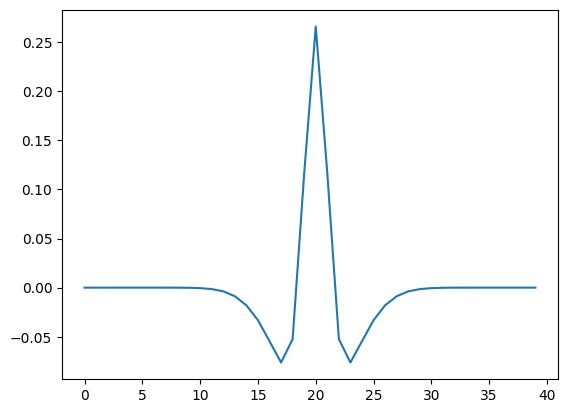

In [58]:
ncfs = on_center_off_surround(40, 0.25, 1.5)
# ncfs = on_center_off_surround(40, 1, 3)
_ = plt.plot(ncfs)

In [59]:
config = dict(
  # data config
  num_dimensions=40,
  xi1=2,
  xi2=1,
  batch_size=1000,
  gain=100,
  dim=1,
  # adjust=(-1, 1),
  adjust=partial(periodic_convolve, h=ncfs),
  class_proportion=0.5,
  # model config
  model_cls=models.SimpleNet,
  activation='relu',
  num_hiddens=2,
  use_bias=False,
  sampler_cls=samplers.EpochSampler,
  init_fn=models.xavier_normal_init,
  init_scale=0.01,
  optimizer_fn=optax.sgd,
  learning_rate=0.2,
  num_epochs=2000,
  # experiment config
  seed=1,#0,
  save_=True,
  evaluation_interval=100,
)

# weights_gauss, metrics_gauss = simulate_or_load(**config, gain=100, dataset_cls=datasets.NLGPGaussianCloneDataset)
# _ = plot_rf_evolution(weights_gauss[-10:], figsize=(8, 4))

weights_nlgp, metrics_nlgp = simulate(**config, dataset_cls=datasets.NonlinearGPDataset)
# _ = plot_rf_evolution(weights_nlgp, figsize=(8, 4))

Using JAX backend: cpu

Using configuration:
{'activation': 'relu',
 'adjust': functools.partial(<function periodic_convolve at 0x153d882c0>, h=Array([-2.9703025e-11, -2.5928165e-10, -2.0252942e-09, -1.4156299e-08,
       -8.8543381e-08, -4.9557315e-07, -2.4820142e-06, -1.1123615e-05,
       -4.4610075e-05, -1.6009020e-04, -5.1409309e-04, -1.4772827e-03,
       -3.7986618e-03, -8.7406291e-03, -1.7996982e-02, -3.3157561e-02,
       -5.4536190e-02, -7.6225057e-02, -5.2491695e-02,  1.1617634e-01,
        2.6596153e-01,  1.1617634e-01, -5.2491695e-02, -7.6225057e-02,
       -5.4536190e-02, -3.3157561e-02, -1.7996982e-02, -8.7406291e-03,
       -3.7986618e-03, -1.4772827e-03, -5.1409309e-04, -1.6009020e-04,
       -4.4610075e-05, -1.1123615e-05, -2.4820142e-06, -4.9557315e-07,
       -8.8543381e-08, -1.4156299e-08, -2.0252942e-09, -2.5928165e-10],      dtype=float32, weak_type=True)),
 'batch_size': 1000,
 'class_proportion': 0.5,
 'dataset_cls': <class 'localization.datasets.nonlinear_gp.N

OCOS: 0.25, 1.5

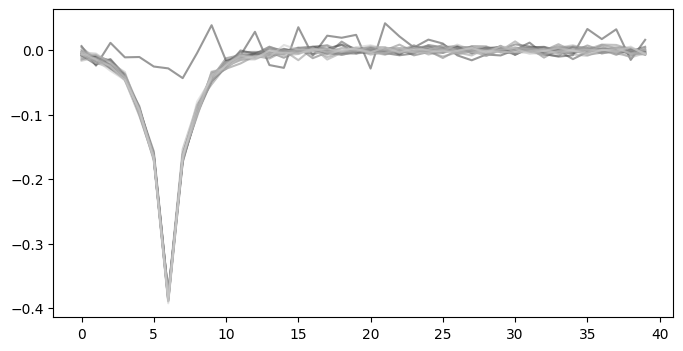

In [48]:
_ = plot_rf_evolution(weights_nlgp, figsize=(8, 4))
# _ = plt.plot(weights_nlgp[-1,0])

OCOS: 1, 3

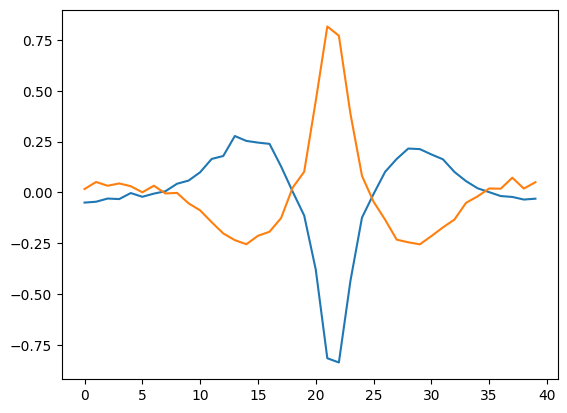

In [60]:
# _ = plt.imshow(weights_nlgp[-1], cmap='gray')
_ = plt.plot(weights_nlgp[-1].T)

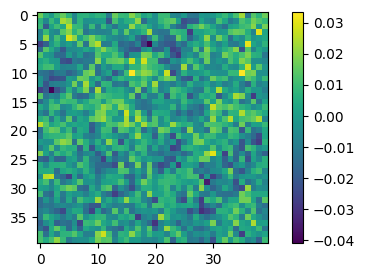

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
im = ax.imshow(weights_nlgp[-1].reshape(40, 40))
cbar = fig.colorbar(im, ax=ax)

## 2D

### On-center off-surround

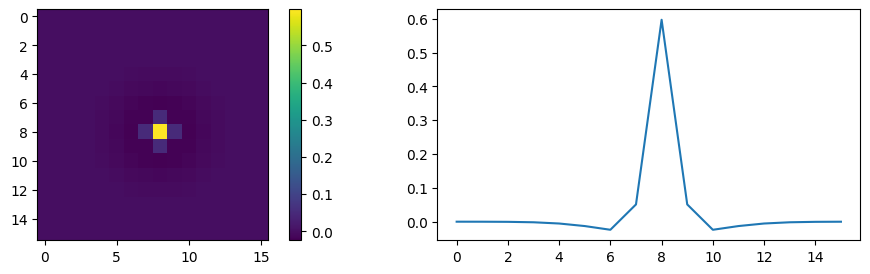

In [2]:
def on_center_off_surround(filter_size, center, surround):
    dist1d = jnp.arange(filter_size) - (filter_size / 2)
    dist = dist1d.reshape(-1,1) ** 2 + dist1d.reshape(1,-1) ** 2
    on = jnp.exp(-dist / (2 * center ** 2)) / (2 * np.pi * center ** 2)
    off = jnp.exp(-dist / (2 * surround ** 2)) / (2 * np.pi * surround ** 2)
    return on - off
# ncfs = on_center_off_surround(16, 0.5, 1)
ncfs = on_center_off_surround(16, 0.5, 2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
im = ax1.imshow(ncfs)
cbar = plt.colorbar(im)
ax2.plot(ncfs[8])

In [3]:
num_dimensions = 80
config = dict(
    num_dimensions=num_dimensions,
    xi1=5,
    xi2=5,
    gain=0.01,
    dim=2,
    seed=0,
    key=jax.random.PRNGKey(0),
)
dataset = datasets.NonlinearGPDataset(**config)
x, y = dataset[:2]

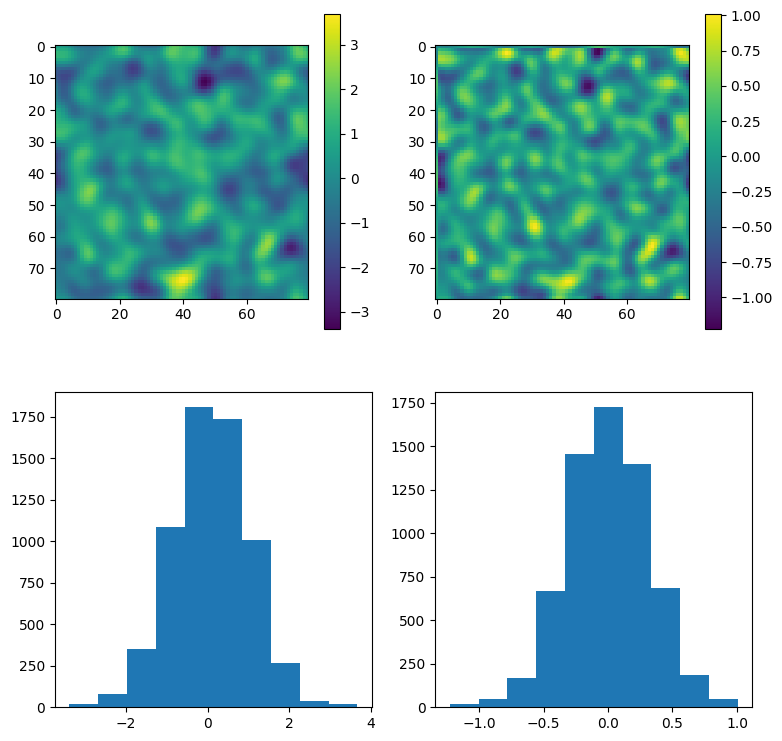

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
# before whitening
im = axs[0,0].imshow(x[0].reshape(num_dimensions, num_dimensions))
cbar = fig.colorbar(im, ax=axs[0,0])
# after whitening
whitened = jax.scipy.signal.convolve2d(x[0].reshape(num_dimensions, num_dimensions), ncfs, mode='same')
im = axs[0,1].imshow(whitened)
cbar = fig.colorbar(im, ax=axs[0,1])
# marginals
_ = axs[1,0].hist(x[0].flatten())
_ = axs[1,1].hist(whitened.flatten())

#### Higher gain

In [6]:
num_dimensions = 80
config = dict(
    num_dimensions=num_dimensions,
    xi1=5,
    xi2=5,
    gain=1,
    dim=2,
    seed=0,
    key=jax.random.PRNGKey(0),
)
dataset = datasets.NonlinearGPDataset(**config)
x, y = dataset[:2]

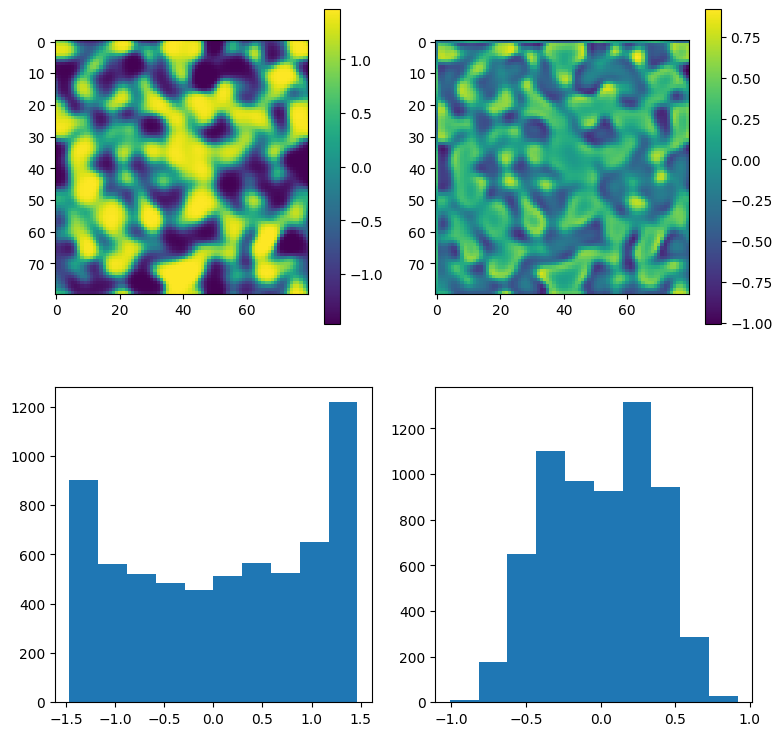

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
# before whitening
im = axs[0,0].imshow(x[0].reshape(num_dimensions, num_dimensions))
cbar = fig.colorbar(im, ax=axs[0,0])
# after whitening
whitened = jax.scipy.signal.convolve2d(x[0].reshape(num_dimensions, num_dimensions), ncfs, mode='same')
im = axs[0,1].imshow(whitened)
cbar = fig.colorbar(im, ax=axs[0,1])
# marginals
_ = axs[1,0].hist(x[0].flatten())
_ = axs[1,1].hist(whitened.flatten())

### Dataset

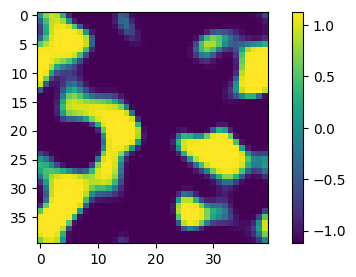

In [18]:
config = dict(
    num_dimensions=40,
    xi1=5,
    xi2=5,
    gain=3,
    dim=2,
    seed=0,
    key=jax.random.PRNGKey(0),
)
dataset = datasets.NonlinearGPDataset(**config)
x, y = dataset[:10]
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
im = ax.imshow(x[0].reshape(40, 40))
cbar = plt.colorbar(im)